In [7]:
import scipy.constants as sc

def calculate_heat_pump_performance(mass_flow_rate, source_temp, dest_temp, compressor_efficiency=0.8):
    # Properties of Water and R290 (Propane)
    cp_water = 4186  # J/kg/K, specific heat capacity of water
    cp_r290 = 1850  # J/kg/K, approximate specific heat capacity of R290

    # Heat absorbed by R290 from the source water (Q_in)
    delta_T_source = source_temp - 10  # assuming the source water cools down to 10°C
    heat_absorbed = mass_flow_rate * cp_water * delta_T_source  # J/s or Watts

    # Heat delivered to the destination water (Q_out)
    delta_T_dest = dest_temp - 20  # assuming destination water heats from 20°C to 60°C
    mass_flow_rate_dest = heat_absorbed / (cp_water * delta_T_dest)  # maintaining energy balance
    heat_delivered = mass_flow_rate_dest * cp_water * delta_T_dest  # J/s or Watts

    # Estimating compressor work (W_compressor)
    # Assuming an isentropic process, use a simplified compression work equation
    # W = (Q_out / COP_ideal) * compressor efficiency
    # For simplicity, assume an initial COP_ideal (this would typically be derived from detailed thermodynamic tables or equations)
    COP_ideal = 5.5  # A placeholder value, normally much more complex calculation involving thermodynamic properties of R290
    compressor_work = heat_delivered / (COP_ideal * compressor_efficiency)  # J/s or Watts

    # Actual COP calculation
    actual_COP = heat_delivered / compressor_work

    # Convert all power values to kW
    heat_absorbed_kW = heat_absorbed / 1000
    heat_delivered_kW = heat_delivered / 1000
    compressor_work_kW = compressor_work / 1000

    return {
        "Heat Absorbed (kW)": heat_absorbed_kW,
        "Heat Delivered (kW)": heat_delivered_kW,
        "Compressor Work (kW)": compressor_work_kW,
        "Coefficient of Performance (COP)": actual_COP
    }

# Inputs
mass_flow_rate = 0.139  # kg/s
source_temp = 20  # °C
dest_temp = 60  # °C
compressor_efficiency = 0.8  # Assume 80% efficiency for calculations

# Calculation
results = calculate_heat_pump_performance(mass_flow_rate, source_temp, dest_temp, compressor_efficiency)

# Output results
for key, value in results.items():
    print(f"{key}: {value:.2f}")



Heat Absorbed (kW): 5.82
Heat Delivered (kW): 5.82
Compressor Work (kW): 1.32
Coefficient of Performance (COP): 4.40


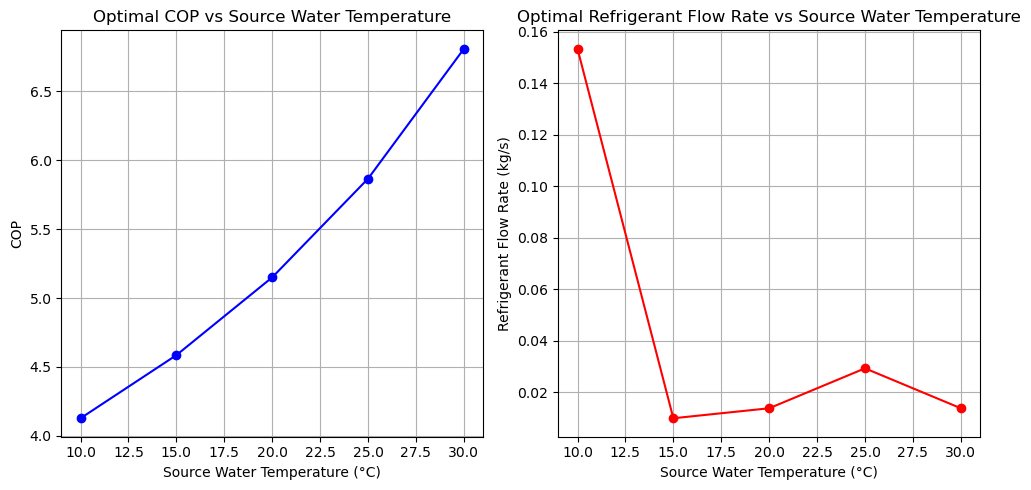

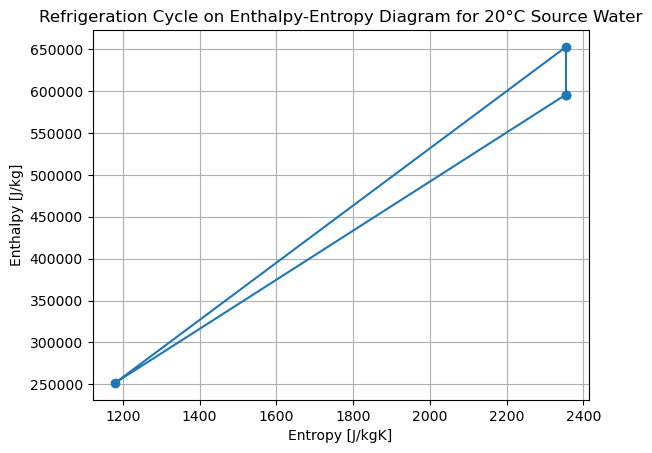

Performance Metrics for Source Temperature of 20°C:
COP: 5.15
Optimal Refrigerant Flow Rate (kg/s): 0.01
Compressor Work (kW): 0.79
Heat Absorbed (kW): 4.06


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP

def calculate_optimal_performance(source_temp, dest_temp, ambient_temp, water_mass_flow_rate, min_refrigerant_flow, max_refrigerant_flow, num_steps):
    fluid = 'R290'  # Propane
    T_source_K = source_temp + 273.15
    T_dest_K = dest_temp + 273.15
    T_ambient_K = ambient_temp + 273.15

    # Define the range for refrigerant mass flow rate
    refrigerant_flows = np.linspace(min_refrigerant_flow, max_refrigerant_flow, num_steps)
    best_cop = 0
    best_flow_rate = 0
    best_compressor_work = 0
    best_heat_absorbed = 0
    cycle_data = None

    for mass_flow_rate in refrigerant_flows:
        P_evap = CP.PropsSI('P', 'T', T_source_K, 'Q', 0, fluid)
        P_cond = CP.PropsSI('P', 'T', T_dest_K, 'Q', 0, fluid)
        h1 = CP.PropsSI('H', 'P', P_evap, 'Q', 1, fluid)
        s1 = CP.PropsSI('S', 'P', P_evap, 'Q', 1, fluid)
        h2s = CP.PropsSI('H', 'P', P_cond, 'S', s1, fluid)
        
        compressor_efficiency = 0.75
        h2 = h1 + (h2s - h1) / compressor_efficiency
        
        compressor_work = (h2 - h1) * mass_flow_rate
        heat_absorbed = (h1 - CP.PropsSI('H', 'T', T_source_K, 'Q', 0, fluid)) * mass_flow_rate
        effective_heat_absorbed = heat_absorbed * 0.85  # Assuming heat exchanger efficiency

        COP = effective_heat_absorbed / compressor_work

        if COP > best_cop:
            best_cop = COP
            best_flow_rate = mass_flow_rate
            best_compressor_work = compressor_work / 1000  # Convert to kW
            best_heat_absorbed = effective_heat_absorbed / 1000  # Convert to kW
            h4 = CP.PropsSI('H', 'P', P_evap, 'Q', 0, fluid)
            s4 = CP.PropsSI('S', 'P', P_evap, 'Q', 0, fluid)
            cycle_data = (h1, s1, h2, s1, h2, s1, h4, s4)  # Updated for realistic transitions

    return best_cop, best_flow_rate, best_compressor_work, best_heat_absorbed, cycle_data

# Parameters
source_temps = np.array([10, 15, 20, 25, 30])
cop_values = []
flow_rates = []
dest_temp = 60
ambient_temp = 10
water_mass_flow_rate = 0.139

# Evaluate each source temperature
for temp in source_temps:
    cop, flow_rate, compressor_work, heat_absorbed, cycle_data = calculate_optimal_performance(
        temp, dest_temp, ambient_temp, water_mass_flow_rate, 0.01, 0.2, 50)
    cop_values.append(cop)
    flow_rates.append(flow_rate)
    if temp == 20:
        base_case_data = cycle_data
        base_case_output = {
            "COP": cop,
            "Optimal Refrigerant Flow Rate (kg/s)": flow_rate,
            "Compressor Work (kW)": compressor_work,
            "Heat Absorbed (kW)": heat_absorbed
        }

# Plotting all required graphs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(source_temps, cop_values, marker='o', linestyle='-', color='b')
plt.title('Optimal COP vs Source Water Temperature')
plt.xlabel('Source Water Temperature (°C)')
plt.ylabel('COP')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(source_temps, flow_rates, marker='o', linestyle='-', color='r')
plt.title('Optimal Refrigerant Flow Rate vs Source Water Temperature')
plt.xlabel('Source Water Temperature (°C)')
plt.ylabel('Refrigerant Flow Rate (kg/s)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot enthalpy-entropy diagram for the base case (20°C)
h1, s1, h2, s2, h3, s3, h4, s4 = base_case_data
plt.figure()
plt.plot([s1, s2, s4, s1], [h1, h2, h4, h1], 'o-')
plt.xlabel('Entropy [J/kgK]')
plt.ylabel('Enthalpy [J/kg]')
plt.title('Refrigeration Cycle on Enthalpy-Entropy Diagram for 20°C Source Water')
plt.grid(True)
plt.show()

# Output the performance metrics for the 20°C case
print("Performance Metrics for Source Temperature of 20°C:")
for key, value in base_case_output.items():
    print(f"{key}: {value:.2f}")


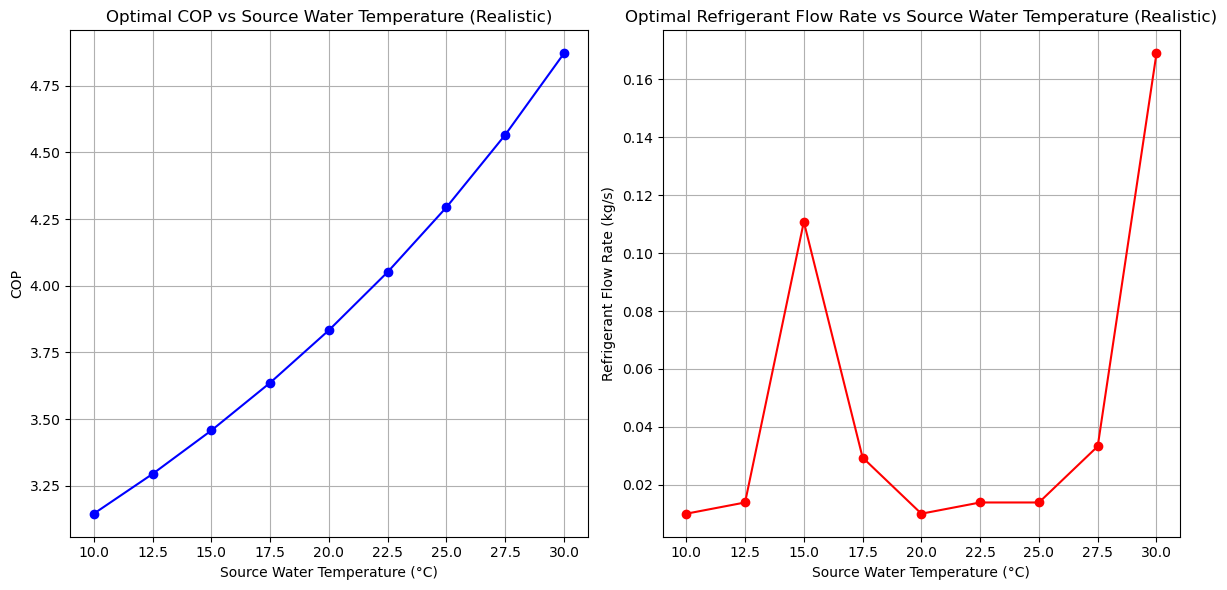

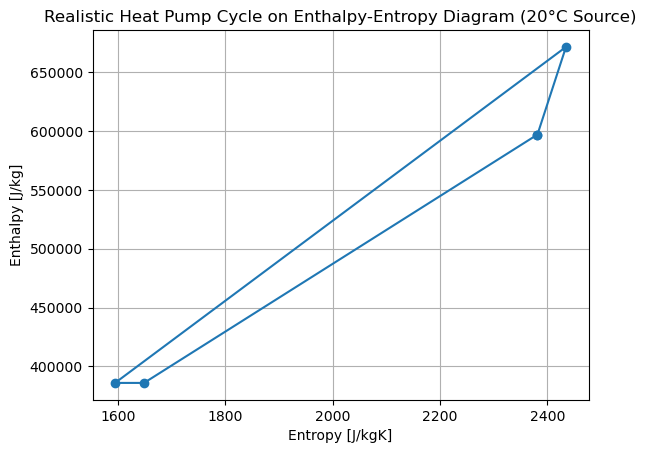

Performance Metrics for Source Temperature of 20°C (Realistic):
COP: 3.83
Optimal Refrigerant Flow Rate (kg/s): 0.01
Compressor Work (kW): 0.74
Heat Delivered (kW): 2.85


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP

def calculate_realistic_performance(
    source_temp, dest_temp,
    min_refrigerant_flow, max_refrigerant_flow, num_steps,
    compressor_efficiency=0.75,
    evaporator_approach=5.0,  # K or °C
    condenser_approach=5.0,   # K or °C
    superheat_K=3.0,          # K
    suction_line_pressure_drop_pa=10000,  # Pascals
    discharge_line_pressure_drop_pa=20000  # Pascals
):
    """
    Calculates the optimal performance of a heat pump cycle with more realistic assumptions.
    """
    fluid = 'R290'  # Propane

    # Adjust for heat exchanger approach temperatures
    T_evap_K = (source_temp - evaporator_approach) + 273.15
    T_cond_K = (dest_temp + condenser_approach) + 273.15

    # Evaporation and Condensation pressures based on adjusted temperatures
    P_evap_sat = CP.PropsSI('P', 'T', T_evap_K, 'Q', 1, fluid)
    P_cond_sat = CP.PropsSI('P', 'T', T_cond_K, 'Q', 0, fluid)

    # Adjust for pressure drops
    P_suction = P_evap_sat - suction_line_pressure_drop_pa
    P_discharge = P_cond_sat + discharge_line_pressure_drop_pa

    # State 1: Superheated vapor entering the compressor
    T1 = T_evap_K + superheat_K
    h1 = CP.PropsSI('H', 'T', T1, 'P', P_suction, fluid)
    s1 = CP.PropsSI('S', 'T', T1, 'P', P_suction, fluid)

    # State 2: Superheated vapor leaving the compressor
    h2s = CP.PropsSI('H', 'P', P_discharge, 'S', s1, fluid)
    h2 = h1 + (h2s - h1) / compressor_efficiency
    s2 = CP.PropsSI('S', 'P', P_discharge, 'H', h2, fluid)

    # State 3: Saturated liquid leaving the condenser
    h3 = CP.PropsSI('H', 'P', P_discharge, 'Q', 0, fluid)
    s3 = CP.PropsSI('S', 'P', P_discharge, 'Q', 0, fluid)

    # State 4: Mixture after expansion valve (throttling)
    h4 = h3
    s4 = CP.PropsSI('S', 'H', h4, 'P', P_suction, fluid)

    # Performance calculation (per kg of refrigerant)
    heat_delivered_per_kg = h2 - h3
    compressor_work_per_kg = h2 - h1

    # Find optimal flow rate
    best_cop = 0
    best_flow_rate = 0
    best_compressor_work = 0
    best_heat_delivered = 0
    
    refrigerant_flows = np.linspace(min_refrigerant_flow, max_refrigerant_flow, num_steps)
    for mass_flow_rate in refrigerant_flows:
        heat_delivered = heat_delivered_per_kg * mass_flow_rate
        compressor_work = compressor_work_per_kg * mass_flow_rate
        
        if compressor_work == 0:
            continue
        
        COP = heat_delivered / compressor_work
        
        if COP > best_cop:
            best_cop = COP
            best_flow_rate = mass_flow_rate
            best_compressor_work = compressor_work / 1000  # kW
            best_heat_delivered = heat_delivered / 1000  # kW

    cycle_data = (h1, s1, h2, s2, h3, s3, h4, s4)
    return best_cop, best_flow_rate, best_compressor_work, best_heat_delivered, cycle_data

# Parameters
dest_temp = 60  # °C
source_temps = np.array([10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30])  # °C

cop_values = []
flow_rates = []
base_case_data = None
base_case_output = {}

# Evaluate each source temperature
for temp in source_temps:
    cop, flow_rate, compressor_work, heat_delivered, cycle_data = calculate_realistic_performance(
        temp, dest_temp, 0.01, 0.2, 50)
    cop_values.append(cop)
    flow_rates.append(flow_rate)
    if temp == 20:
        base_case_data = cycle_data
        base_case_output = {
            "COP": cop,
            "Optimal Refrigerant Flow Rate (kg/s)": flow_rate,
            "Compressor Work (kW)": compressor_work,
            "Heat Delivered (kW)": heat_delivered
        }

# Plotting COP and refrigerant flow rates
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(source_temps, cop_values, marker='o', linestyle='-', color='blue')
plt.title('Optimal COP vs Source Water Temperature (Realistic)')
plt.xlabel('Source Water Temperature (°C)')
plt.ylabel('COP')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(source_temps, flow_rates, marker='o', linestyle='-', color='red')
plt.title('Optimal Refrigerant Flow Rate vs Source Water Temperature (Realistic)')
plt.xlabel('Source Water Temperature (°C)')
plt.ylabel('Refrigerant Flow Rate (kg/s)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot enthalpy-entropy diagram for the 20°C case
if base_case_data:
    h1, s1, h2, s2, h3, s3, h4, s4 = base_case_data
    plt.figure()
    plt.plot([s1, s2, s3, s4, s1], [h1, h2, h3, h4, h1], 'o-')
    plt.xlabel('Entropy [J/kgK]')
    plt.ylabel('Enthalpy [J/kg]')
    plt.title('Realistic Heat Pump Cycle on Enthalpy-Entropy Diagram (20°C Source)')
    plt.grid(True)
    plt.show()

# Output the performance metrics for the 20°C case
if base_case_output:
    print("Performance Metrics for Source Temperature of 20°C (Realistic):")
    for key, value in base_case_output.items():
        print(f"{key}: {value:.2f}")
else:
    print("Could not calculate performance metrics for 20°C case.")